# Sprawozdanie z **Obliczeń ewolucyjnych**
## Zadanie 2 

# Konfiguracja
Przy pomocy klasy Config można wybrać zastosowany algorytm oraz określić jego parametry:    
- w - współczynnik zmęczenia.   
- c1 - współczynnik przyspieszenia w kierunku własnego minimum cząstki
- c2 - współczynnik przyspieszenia w kierunku globalnego minimum cząstek
- iterations - ilość iteracji algorytmu  
- target_error - najniższy stopień błędu - po osiągnięciu tego wyniku algorytm zatrzymuje się  
- n_particles - ilość cząstek  
- arguments_dimensions - liczba wymiarów, w których rozkładane są cząsteczki   
- d_min - minimalna wartość współrzędnej dla każdego z wymiarów   
- d_max - maksymalna wartość współrzędnej dla każdego z wymiarów   
- fitness - wybór funkcji dostosowującej położenie cząstek         
 Dla celów badawczych, w dalszej części zaprezentowane są różne zestawy wartości konfiguracyjnych.

In [2]:
!pip install deap > /dev/null
# !pip install k3d > /dev/null
%matplotlib notebook

In [33]:
from pathlib import Path
import json

class Config(object): 
    def __init__(self, TYPE, CHI, C, P, DIST, DIMS, NSWARMS, NPARTICLES, NEXCESS, RCLOUD, EVALS):
        self.CHI = CHI        
        self.TYPE = TYPE
        self.C = C
        self.P = P
        self.DIST = DIST
        self.DIMS = DIMS
        self.NSWARMS = NSWARMS
        self.NPARTICLES = NPARTICLES
        self.NEXCESS = NEXCESS
        self.RCLOUD = RCLOUD
        self.EVALS = EVALS

def as_config(dct):
    return Config(
        dct['TYPE'],        
        dct['CHI'],
        dct['C'],
        dct['P'],
        dct['DIST'],
        dct['DIMS'],
        dct['NSWARMS'],
        dct['NPARTICLES'], 
        dct['NEXCESS'], 
        dct['RCLOUD'],
        dct['EVALS'],
        )

# Algorytm MPSO

### Imports

In [30]:
import itertools
import math
import operator
import random
from statistics import mean
import time

import numpy
np = numpy
from deap import base
from deap.benchmarks import movingpeaks
from deap import creator
from deap import tools

#plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

#random
from numpy import random as nrand
nrand.seed(0)
from random import seed
seed(0)

### Plots

In [38]:
flatten = lambda l: [item for sublist in l for item in sublist]
figsize = (14, 8)
def annot_min(x,y, ax=None):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin/(len(x)*0.65),-0.02), **kw)

def hist_over_time(result_book, single_gen_index=None,
                   min_hist_value=1, sift_rate=2,
                   skip_first=100, limits=(-250, 70)):
    hists = result_book.select("hist")
    hists = hists[skip_first:] # skip first 100 evals
    hists = hists[0::sift_rate] # take one in 4
    hists = [h for h in hists if h]
    all_z_points = flatten([a[0].tolist() for a in hists])
    all_x_points = flatten([((a[1][1:] + a[1][:-1])/2).tolist() for a in hists])
    all_y_points = flatten([np.full(len(x[1]), x[0]) for x in [(a,hists[a][0]) for a in range(len(hists))]])
    size =  len(all_z_points)
    p = 0
    while p < size:
        if all_z_points[p] < min_hist_value:
            del all_z_points[p]
            del all_x_points[p]
            del all_y_points[p]
            size = size - 1
            p = p - 1
        p = p + 1
    fig = plt.figure(figsize=figsize, dpi=100)
#     ax = Axes3D(fig)
#     surf = ax.plot_trisurf(all_x_points, all_y_points, all_z_points, cmap='inferno', linewidth=0.03, shade=True)
    ax = plt.axes(projection="3d", title="Value of particles fitness's histogram across generations (in Z)")
    ax.scatter3D(all_x_points, all_y_points, all_z_points, c=all_z_points, cmap='inferno');
    ax.set_xlim(limits[0], limits[1])
    plt.show()

    if single_gen_index:
        res = np.array(result_book.select("hist")[single_gen_index])
        z_points = res[0]
        x_points = (res[1][1:] + res[1][:-1])/2
        print(x_points)
        y_points = np.zeros(len(z_points))
        fig = plt.figure()
        ax = plt.axes(projection="3d")
        print(f"{len(z_points)} = {len(x_points)} = {len(y_points)}")
        ax.scatter3D(x_points, y_points, z_points, c=y_points, cmap='inferno');
        plt.show()
        
def plots_nswarms(result_book, top_limit=10):
    swarms = result_book.select("nswarm")
    swarms = [s for s in swarms]
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Number of swarms across generations")
    ax.set_ylim(0, top_limit)
    ax.scatter(range(len(swarms)), swarms, c=swarms, cmap='copper');
    plt.show()

def plot_offline_error(result_book):
    off_error = result_book.select("offline_error")
    off_error = np.array(off_error)

    fig = plt.figure(figsize=figsize, dpi=55)
    ax = plt.axes(title="Offline error across generations")
    ax.scatter(range(len(off_error)), off_error, c=off_error, cmap='coolwarm');
    annot_min(range(len(off_error)), off_error)
    plt.show()

def plot_error(result_book):
    error = result_book.select("error")
    error = np.array(error)
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Error across generations")
    # ax.scatter(range(len(error)), error, s=10, c=error, cmap='coolwarm')
    ax.plot(range(len(error)), error)
    annot_min(range(len(error)), error)
    plt.show()

### Creator

In [32]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    best=None, bestfit=creator.FitnessMax)
creator.create("Swarm", list, best=None, bestfit=creator.FitnessMax)

def generate(pclass, dim, pmin, pmax, smin, smax):
    part = pclass(random.uniform(pmin, pmax) for _ in range(dim)) 
    part.speed = [random.uniform(smin, smax) for _ in range(dim)]
    return part

/opt/conda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Swarm' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


### Update particles

In [25]:
def convertQuantum(swarm, rcloud, centre, dist):
    dim = len(swarm[0])
    for part in swarm:
        position = [random.gauss(0, 1) for _ in range(dim)]
        dist = math.sqrt(sum(x**2 for x in position))
        
        if dist == "gaussian":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif dist == "uvd":
            u = random.random()
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif dist == "nuvd":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u / dist) + c for x, c in zip(position, centre)]
        
        del part.fitness.values
        del part.bestfit.values
        part.best = None
    
    return swarm

def updateParticleMPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

def updateParticleMSPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]
    
def updateEliteParticles(population):
    for updateSwarm in population:
        lbest = [swarm[0] for swarm in population if swarm != updateSwarm]
        mean = np.mean(lbest, axis=0)
        N = nrand.uniform(1, 2, len(updateSwarm.best))
        updateSwarm[0][:] = list(map(operator.mul,
                           mean,
                           N))
from math import pow
def updateParticleBOA(part, best, c, a, p):
    r = random.uniform(0, 1)
    fragrance = c*(pow(part.fitness.values[0], a))
    r1 = (r**2 * random.uniform(0, 1) - random.uniform(0, 1) for _ in range(len(part)))
    if r < p:
        move = map(operator.mul,
                map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(r**2),
                                    best),
                    part),
                itertools.repeat(fragrance))
    else:
        move = map(operator.mul,
                   itertools.repeat(fragrance),
                   r1)
    part[:] = list(map(operator.add, part, move))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

### Toolbox

In [26]:
def setup_toolbox(BOUNDS, mpb):    
    toolbox = base.Toolbox()
    toolbox.register("particle", generate, creator.Particle, dim=cfg.DIMS,
        pmin=BOUNDS[0], pmax=BOUNDS[1], smin=-(BOUNDS[1] - BOUNDS[0])/2.0,
        smax=(BOUNDS[1] - BOUNDS[0])/2.0)
    toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)
    if cfg.TYPE == "MPSO":
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "MSPSO":
        toolbox.register("update", updateParticleMSPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "BOA":
        toolbox.register("update", updateParticleBOA, p=cfg.P)
    else:
        toolbox.register("update", updateParticle, chi=cfg.CHI, c=cfg.C)
    toolbox.register("convert", convertQuantum, dist=cfg.DIST)
    toolbox.register("evaluate", mpb)
    toolbox.register("eliteupdate", updateEliteParticles)
    return toolbox

### App

In [34]:
class App():
    def register_stats(self, should_plot):
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", numpy.mean)
        stats.register("std", numpy.std)
        stats.register("min", numpy.min)
        stats.register("max", numpy.max)        
        logbook = tools.Logbook()
        if should_plot:
            stats.register("hist", lambda a: numpy.histogram(a, bins="auto"))
            logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max", "hist"
        else:
            logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max"
        return stats, logbook
    def boa(self, should_plot):
        # Single swarm only
        cfg.NPARTICLES, cfg.NSWARMS = cfg.NPARTICLES*cfg.NSWARMS, 1
        c, a = 0.01, 0.1
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]

        # Evaluate each particle
        for swarm in population:
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness
        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Update and evaluate the swarm
            for swarm in population:
                swarm.best = None
                for part in swarm:
                    part.fitness.values = toolbox.evaluate(part)
                    # Update global best
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values
                for part in swarm:
                    toolbox.update(part, swarm.best, c, a)

            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)
            if a < 0.5:
                a = a + 0.001
            generation += 1
        return logbook

    def mspso(self, should_plot):
        verbose=False
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]

        # Evaluate each particle
        for swarm in population:
            elite_part_index = None
            for i, part in enumerate(swarm):
                part.fitness.values = toolbox.evaluate(part)
                # Find elite particle
                if not elite_part_index or swarm[elite_part_index].bestfit < part.bestfit:
                    elite_part_index = i
                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])          # Get the position
                    part.bestfit.values = part.fitness.values   # Get the fitness
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness
            swarm[0], swarm[elite_part_index] = swarm[elite_part_index], swarm[0]
        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

#         if verbose:
#             print(logbook.stream)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Check for convergence
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))

            toolbox.eliteupdate(population)
            
            # Update and evaluate the swarm
            for swarm in population:
                # Check for change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    # Convert particles to quantum particles
                    swarm[:] = toolbox.convert(swarm, rcloud=cfg.RCLOUD, centre=swarm.best)
                    swarm.best = None
                    del swarm.bestfit.values
                elite_part_index = None
                for i, part in enumerate(swarm):
                    # Not necessary to update if it is a new swarm
                    # or a swarm just converted to quantum
                    if swarm.best and part.best and i != 0:
                        toolbox.update(part, swarm.best)
                    part.fitness.values = toolbox.evaluate(part)
                    # Find elite particle
                    if not elite_part_index or swarm[elite_part_index].bestfit < part.bestfit:
                        elite_part_index = i
                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values
                swarm[0], swarm[elite_part_index] = swarm[elite_part_index], swarm[0]
            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

            if verbose:
                print(logbook.stream)

            # Apply exclusion
            reinit_swarms = set()
            for s1, s2 in itertools.combinations(range(len(population)), 2):
                # Swarms must have a best and not already be set to reinitialize
                if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                    dist = 0
                    for x1, x2 in zip(population[s1].best, population[s2].best):
                        dist += (x1 - x2)**2.
                    dist = math.sqrt(dist)
                    if dist < rexcl:
                        if population[s1].bestfit <= population[s2].bestfit:
                            reinit_swarms.add(s1)
                        else:
                            reinit_swarms.add(s2)

            # Reinitialize and evaluate swarms
            for s in reinit_swarms:
                population[s] = toolbox.swarm(n=cfg.NPARTICLES)
                for part in population[s]:
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not population[s].best or part.fitness > population[s].bestfit:
                        population[s].best = toolbox.clone(part[:])
                        population[s].bestfit.values = part.fitness.values
            generation += 1
        return logbook

    def mpso(self, should_plot):
        verbose=True
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]
        # Evaluate each particle
        for swarm in population:
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])          # Get the position
                    part.bestfit.values = part.fitness.values   # Get the fitness
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness

        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

#         if verbose:
#             print(logbook.stream)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Check for convergence
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))

            not_converged = 0
            worst_swarm_idx = None
            worst_swarm = None
            for i, swarm in enumerate(population):
                # Compute the diameter of the swarm
                for p1, p2 in itertools.combinations(swarm, 2):
                    d = math.sqrt(sum((x1 - x2)**2. for x1, x2 in zip(p1, p2)))
                    if d > 2*rexcl:
                        not_converged += 1
                        # Search for the worst swarm according to its global best
                        if not worst_swarm or swarm.bestfit < worst_swarm.bestfit:
                            worst_swarm_idx = i
                            worst_swarm = swarm
                        break

            # If all swarms have converged, add a swarm
            if not_converged == 0:
                population.append(toolbox.swarm(n=cfg.NPARTICLES))
            # If too many swarms are roaming, remove the worst swarm
            elif not_converged > cfg.NEXCESS:
                population.pop(worst_swarm_idx)

            # Update and evaluate the swarm
            for swarm in population:
                # Check for change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    # Convert particles to quantum particles
                    swarm[:] = toolbox.convert(swarm, rcloud=cfg.RCLOUD, centre=swarm.best)
                    swarm.best = None
                    del swarm.bestfit.values

                for part in swarm:
                    # Not necessary to update if it is a new swarm
                    # or a swarm just converted to quantum
                    if swarm.best and part.best:
                        toolbox.update(part, swarm.best)
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values

            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

#             if verbose:
#                 print(logbook.stream)

            # Apply exclusion
            reinit_swarms = set()
            for s1, s2 in itertools.combinations(range(len(population)), 2):
                # Swarms must have a best and not already be set to reinitialize
                if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                    dist = 0
                    for x1, x2 in zip(population[s1].best, population[s2].best):
                        dist += (x1 - x2)**2.
                    dist = math.sqrt(dist)
                    if dist < rexcl:
                        if population[s1].bestfit <= population[s2].bestfit:
                            reinit_swarms.add(s1)
                        else:
                            reinit_swarms.add(s2)

            # Reinitialize and evaluate swarms
            for s in reinit_swarms:
                population[s] = toolbox.swarm(n=cfg.NPARTICLES)
                for part in population[s]:
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not population[s].best or part.fitness > population[s].bestfit:
                        population[s].best = toolbox.clone(part[:])
                        population[s].bestfit.values = part.fitness.values
            generation += 1
        return logbook
    def run(self, should_plot=True):
        result = None
        if cfg.TYPE == "MPSO":
            return self.mpso(should_plot)
        elif cfg.TYPE == "MSPSO":
            return self.mspso(should_plot)
        elif cfg.TYPE == "BOA":
            return self.boa(should_plot)
        else:
            return self.mpso(should_plot)
    
def plot_results(logbook):
        hist_over_time(logbook)
        plots_nswarms(logbook, top_limit=cfg.NSWARMS*2)
        plot_offline_error(logbook)
        plot_error(logbook)

# Testy

#### Offline error
Podstawową miarą zastosowaną do oceny jakości algorytmów jest tzw. "offline error", który jest popularną metryką stosowaną w problemach o dynamicznych warunkach. Przeprowadzono 30 iteracji każdego algorytmu, aby wybrać na potrzeby dalszych kroków jeden z algorytmów

In [11]:
results = [App().run(should_plot=False) for i in range(50)]
mean_offline_error = np.mean([r.select("offline_error")[-1] for r in results])
print(mean_offline_error)

3.60107050702525


In [37]:
json_config ="""
{
    "TYPE": "BOA",
    "CHI": 0.729843788,
    "C": 2.05,
    "DIST": "nuvd",
    "DIMS": 5,
    "NSWARMS": 1,
    "NPARTICLES": 50,
    "NEXCESS": 1,
    "RCLOUD": 0.5,
    "EVALS": 500000,
    "P": 0.8
}"""
cfg = json.loads(json_config, object_hook = as_config)
results = [App().run(should_plot=False) for i in range(30)]
mean_offline_error = np.mean([r.select("offline_error")[-1] for r in results])
print(mean_offline_error)

63.06951978415372


In [36]:
json_config ="""
{
    "TYPE": "MSPSO",
    "CHI": 0.729843788,
    "C": 2.05,
    "DIST": "nuvd",
    "DIMS": 5,
    "NSWARMS": 10,
    "NPARTICLES": 6,
    "NEXCESS": 1,
    "RCLOUD": 0.5,
    "EVALS": 500000,
    "P": 0.8
}"""
cfg = json.loads(json_config, object_hook = as_config)
results = [App().run(should_plot=False) for i in range(30)]
mean_offline_error = np.mean([r.select("offline_error")[-1] for r in results])
print(mean_offline_error)

21.113062921183502


#### Wybrano algorytm MPSO, który uzyskać znacząco najlepszy wynik: 3,60

Algoryt

--- 20.1915 seconds ---


<IPython.core.display.Javascript object>


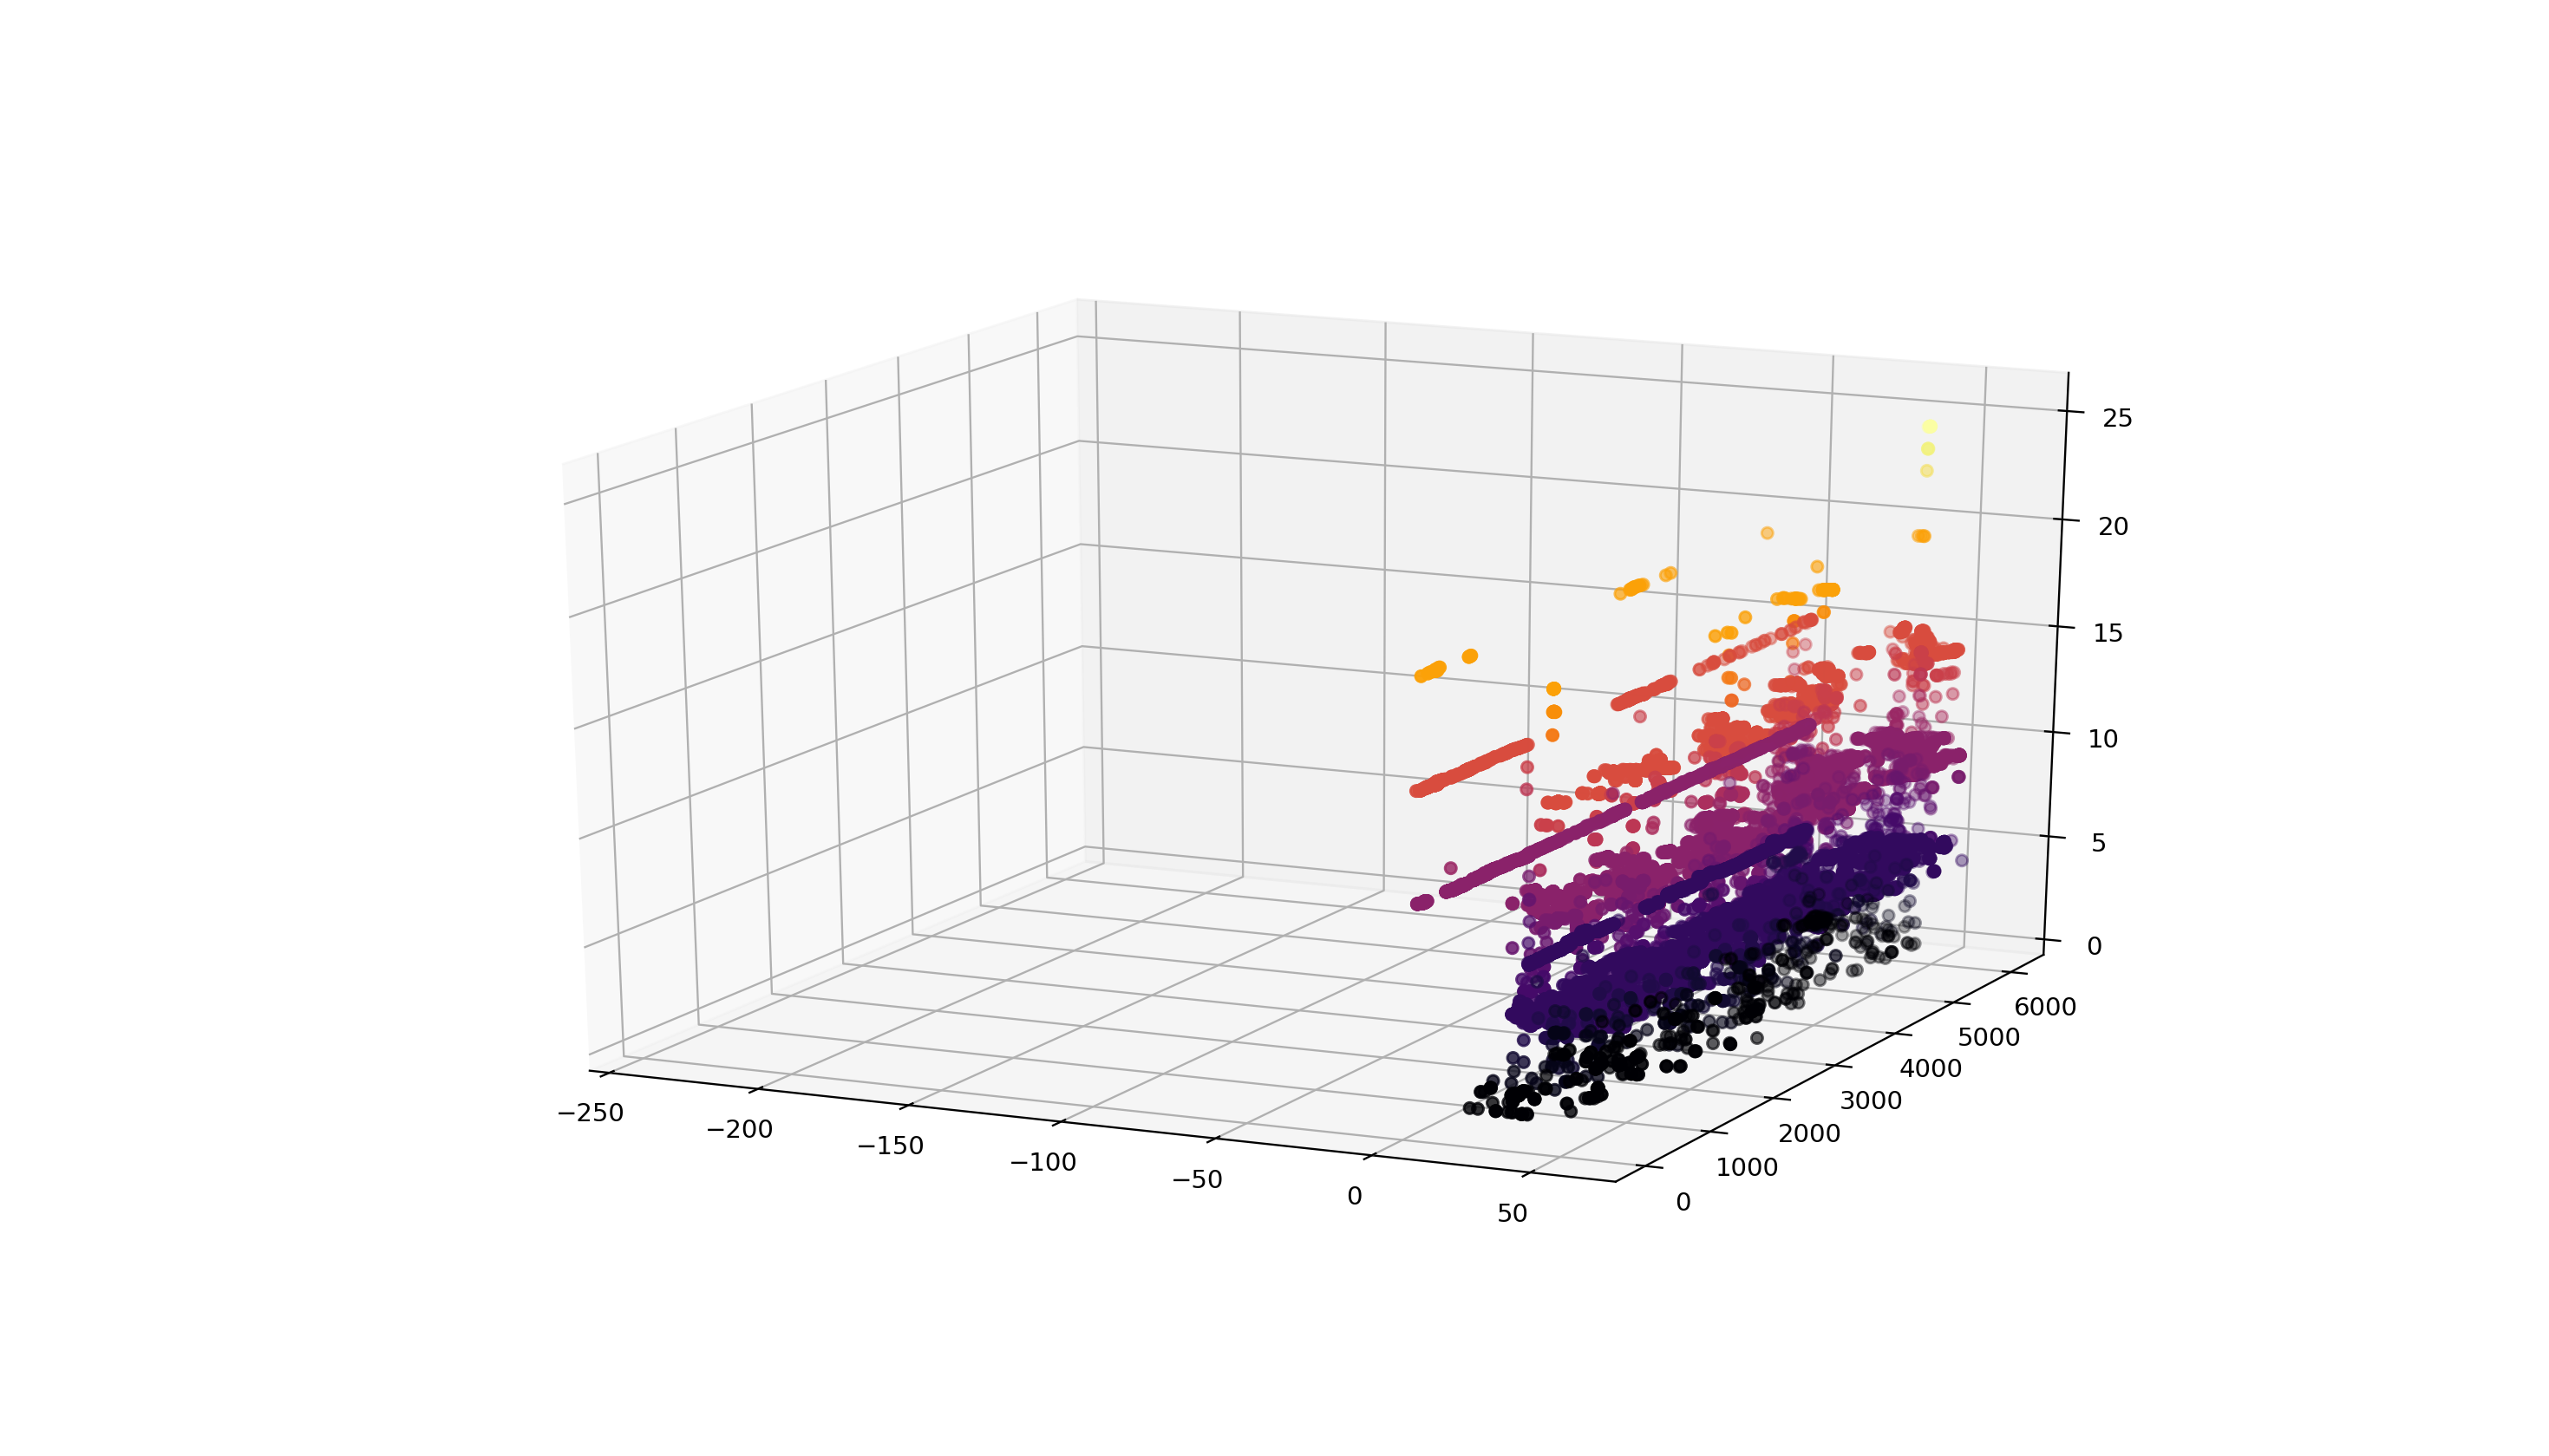

<IPython.core.display.Javascript object>


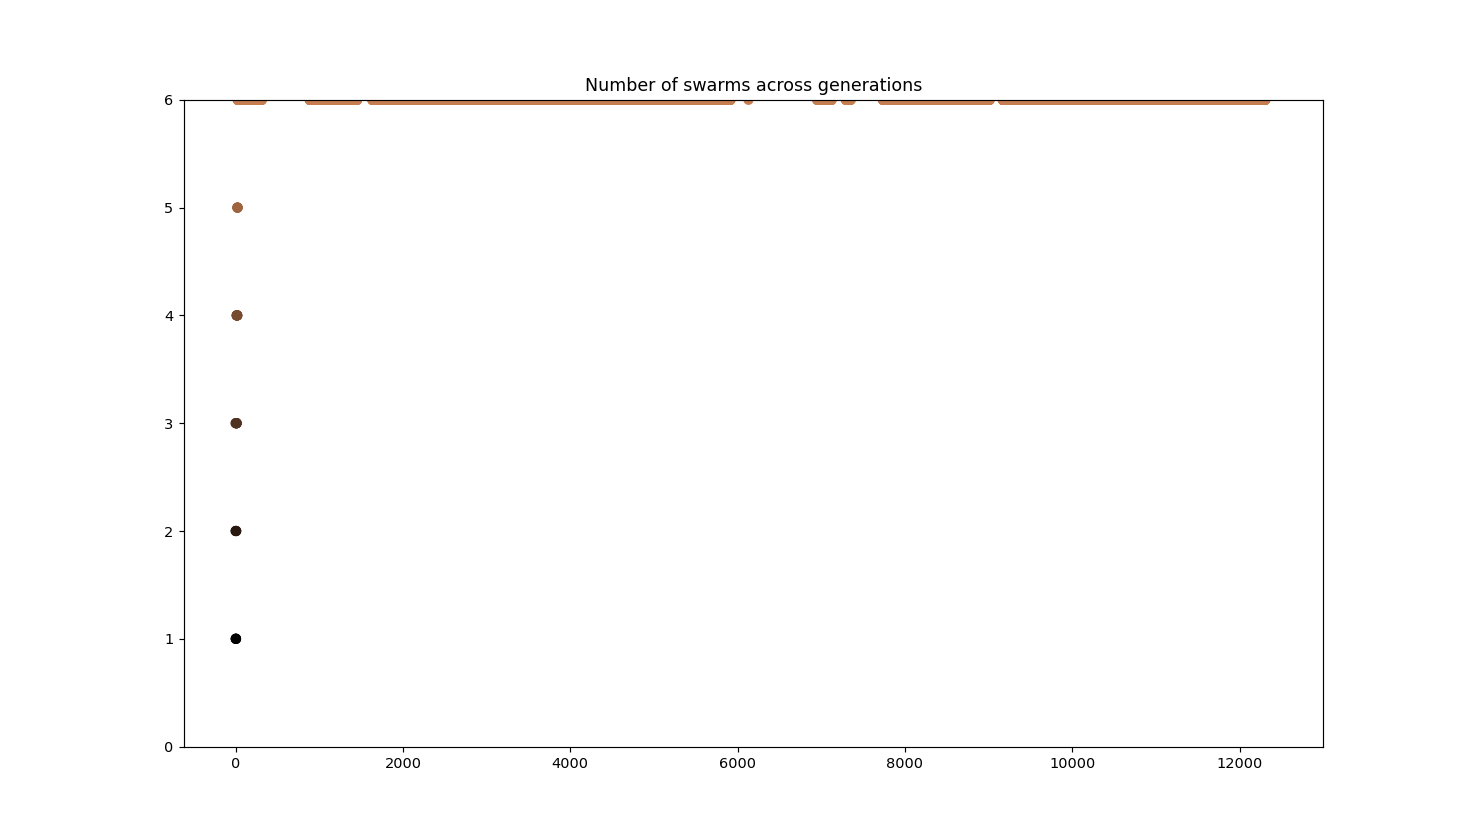

<IPython.core.display.Javascript object>


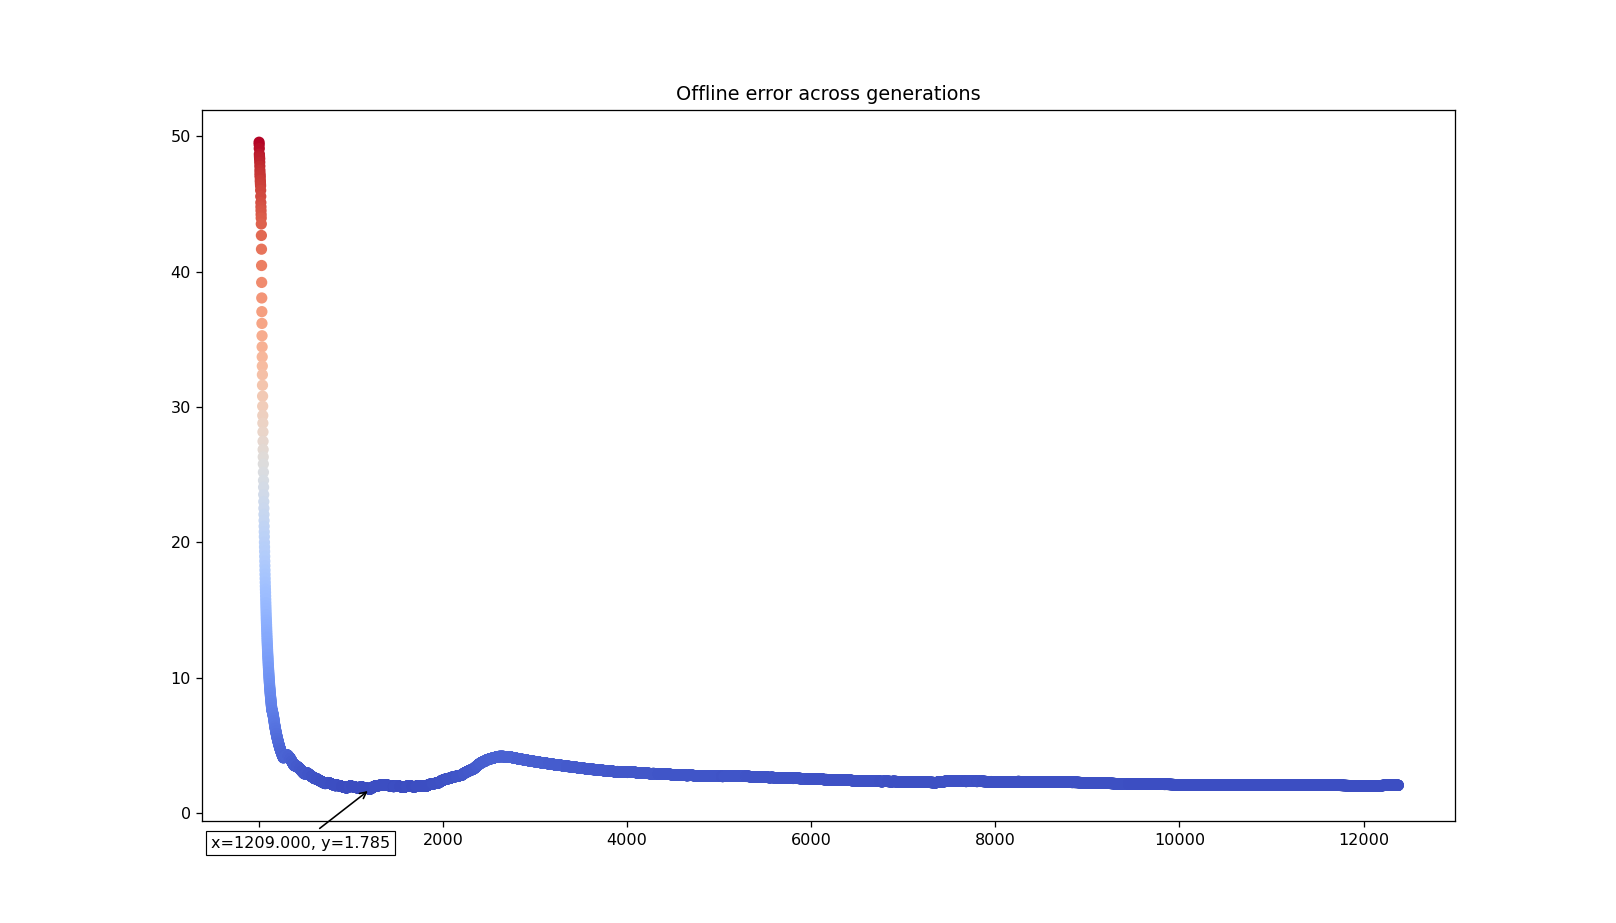

<IPython.core.display.Javascript object>


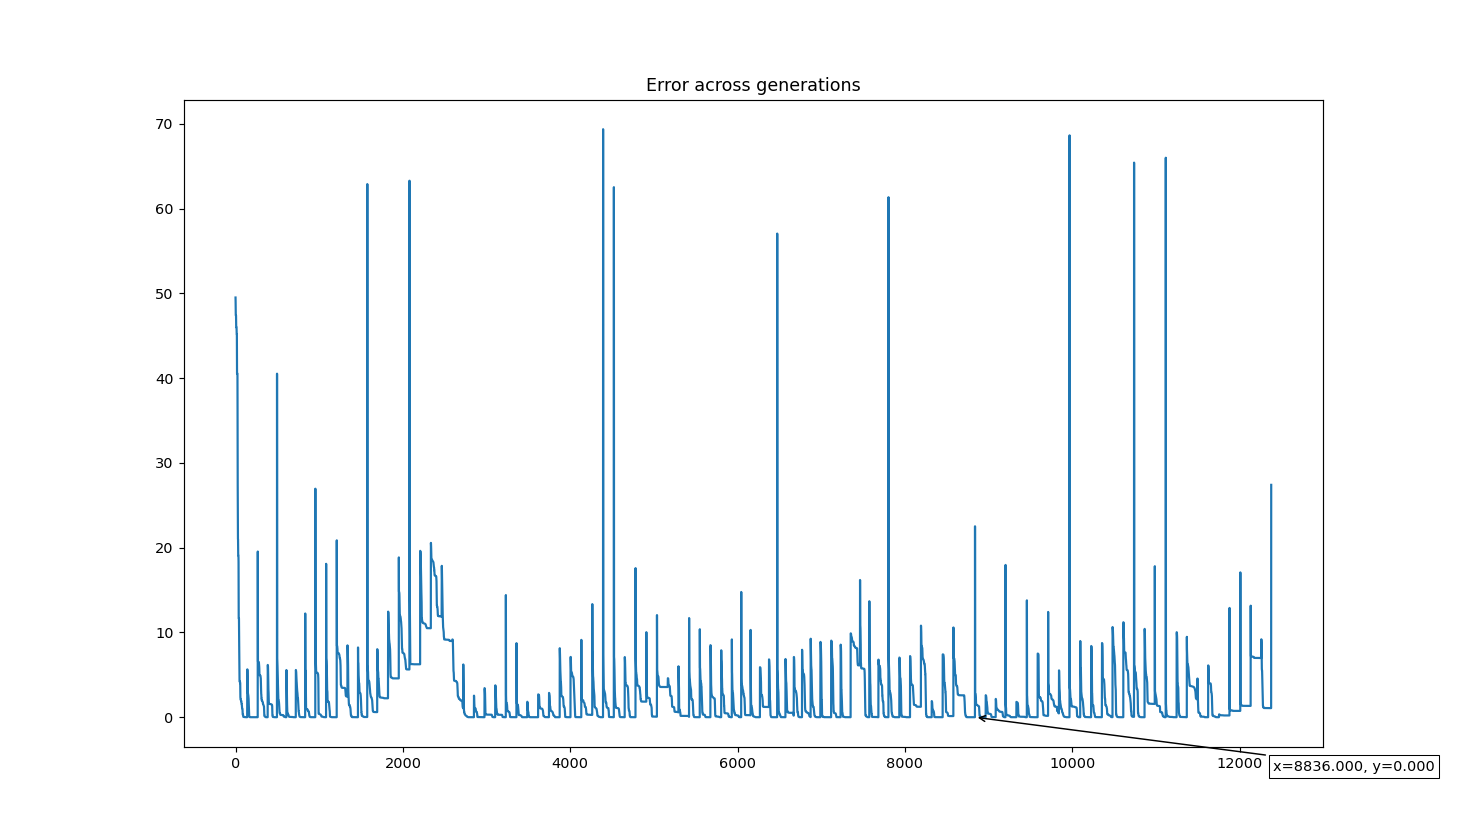

In [35]:
json_config ="""
{
    "TYPE": "MPSO",
    "CHI": 0.729843788,
    "C": 2.05,
    "DIST": "nuvd",
    "DIMS": 5,
    "NSWARMS": 3,
    "NPARTICLES": 5,
    "NEXCESS": 1,
    "RCLOUD": 0.5,
    "EVALS": 500000,
    "P": 0.8
}"""
cfg = json.loads(json_config, object_hook = as_config)

start_time = time.time()
result_book = App().run()
print("---Czas obliczania algorytmu %.4f seconds ---" % (time.time() - start_time))
plot_results(result_book)